In [226]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from polygon import RESTClient
import datetime as dt
from pandas.tseries.offsets import BDay
from sklearn.linear_model import LinearRegression
from matplotlib.ticker import PercentFormatter

import requests 
import time
import json
import seaborn as sns
import math

client = RESTClient('tt2gOLH0fHAmPX70a4QURLFy59PRCZr3')
API_key = 'tt2gOLH0fHAmPX70a4QURLFy59PRCZr3'

In [2]:
import stock_data_functions
import importlib

# After editing stock_data_functions.py and saving changes:
importlib.reload(stock_data_functions)

from stock_data_functions import TickerData

class GroupComparison():

    def __init__(self, tickers : list[str], filing_date_gte : str):

        self.tickers = tickers
        self.filing_date_gte = filing_date_gte

        tickers_time_series = {}
        tickers_earning_dates = {}

        counter = 0
        for i in tickers:
            ticker_i                    = TickerData(i, self.filing_date_gte)
            ticker_i.get_ratios()
            ticker_i.map_earnings_to_prices()
            ticker_i.calc_zscore_and_rets()
            tickers_time_series[i]      = ticker_i.summary_returns_data
            tickers_earning_dates[i]    = ticker_i.earning_dates_with_prices
            counter = counter + 1
            if len(tickers) > 5:
                time.sleep(15) 

        self.tickers_time_series        = pd.concat(tickers_time_series,axis=1)
        self.tickers_earnings           = tickers_earning_dates

            
    def analyse_correlations(self, ticker_X, ticker_y, plot : bool = True, returns : str = 'vwap'):
        """
        Given two tickers, compute the betas to each other, correlation, and plot scatter
        """
        X = self.tickers_time_series.loc[:, (ticker_X, returns)].to_numpy().reshape(-1,1)
        y = self.tickers_time_series.loc[:, (ticker_y, returns)]

        model       = LinearRegression(fit_intercept=False).fit(X,y)
        beta_coef   = model.coef_[0]
        r2          = model.score(X,y)

        if plot == True:
            plt.title(f'Slope : {np.round(beta_coef,2)}\nR^2 {np.round(r2,2)}')

            plt.scatter(X,y)
            plt.xlabel(f"{ticker_X}")
            plt.ylabel(f'{ticker_y}')
            plt.legend()
            plt.show()
    

In [ ]:
stocks = GroupComparison(tickers=['AVGO', 'MU', 'AMD'], filing_date_gte='2023-09-25')

/var/folders/2_/q3fhp8js4zgd2w2m2cb4y8rh0000gn/T/ipykernel_1478/3924764776.py:52: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


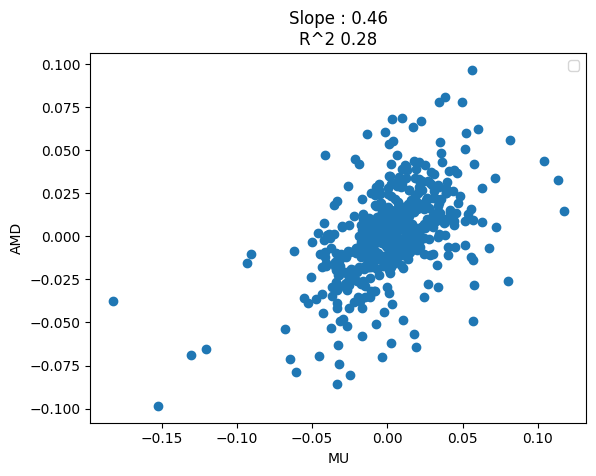

In [404]:
stocks.analyse_correlations('MU', 'AMD')

Text(0, 0.5, '$ Dollars')

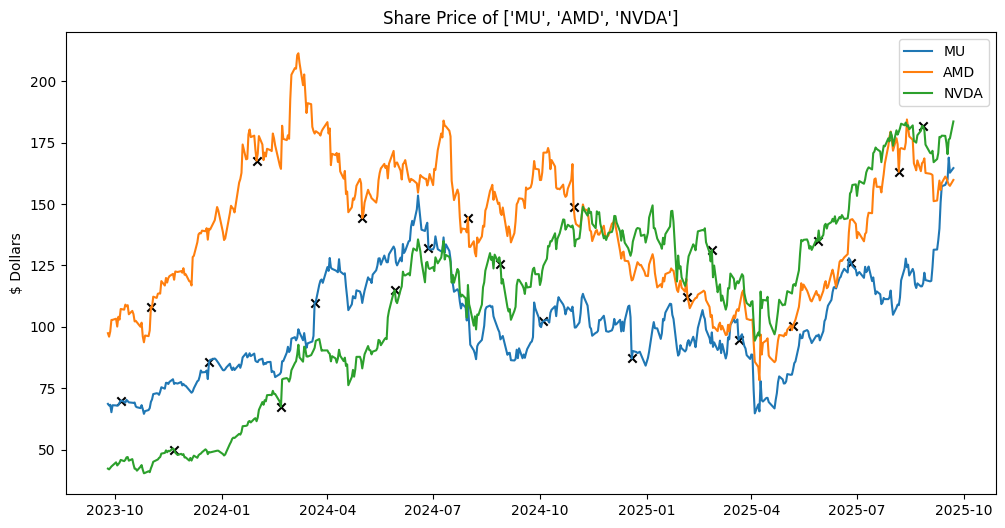

In [ ]:
plt.figure(figsize=(12,6))

for i in tickers:
    price_returns = test.tickers_time_series[i].copy()
    earnings         = test.tickers_earnings[i]
    plt.scatter(earnings.index, earnings['close'],marker='x', color='black')
    plt.plot(price_returns['close'], label=i)
    plt.legend()
    
plt.title(f'Share Price of {tickers}')
plt.ylabel('$ Dollars')



In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=None)   
pca.fit(rets)

# Components (eigenvectors, loadings)
loadings = pd.DataFrame(
    pca.components_.T,
    index=rets.columns,
    columns=[f"PC{i+1}" for i in range(len(rets.columns))]
)

# Explained variance ratio
explained_var = pd.Series(pca.explained_variance_ratio_,
                          index=loadings.columns)

print("Explained variance ratio:")
print(explained_var)

print("\nLoadings (feature weights per PC):")
print(loadings)

# Transform data into PC scores
scores = pd.DataFrame(
    pca.transform(rets),
    index=rets.index,
    columns=loadings.columns
)


Explained variance ratio:
PC1    0.717164
PC2    0.173126
PC3    0.109710
dtype: float64

Loadings (feature weights per PC):
           PC1       PC2       PC3
MU    0.641544  0.753591 -0.143255
AMD   0.533588 -0.572578 -0.622445
NVDA  0.551094 -0.322887  0.769441


In [1]:
import stock_data_functions
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from scipy.stats import boxcox

# After editing stock_data_functions.py and saving changes:
import importlib

importlib.reload(stock_data_functions)

from stock_data_functions import TickerData, calc_log_rets

### Doing OLS Regression

In [4]:
AVGO = TickerData('AVGO', '2023-09-25')
AVGO.get_historical_prices()
AVGO.get_ratios()
AVGO.calc_zscore_and_rets()
y_df = AVGO.summary_returns_data
y    = y_df['close']

Call AVGO.calc_zscore_and_rets() to get returns data
Request URL: https://api.polygon.io/v2/aggs/ticker/AVGO/range/1/day/2023-09-25/2025-09-26?limit=5000
Request Headers: {'Authorization': 'Bearer REDACTED', 'Accept-Encoding': 'gzip', 'User-Agent': 'Polygon.io PythonClient/1.15.3'}
Response Headers: {'Date': 'Sun, 28 Sep 2025 18:54:14 GMT', 'Content-Type': 'application/json', 'Transfer-Encoding': 'chunked', 'Connection': 'keep-alive', 'Content-Encoding': 'gzip', 'Vary': 'Accept-Encoding', 'X-Polygon-Cluster-Name': 'polygon-ny5', 'X-Request-Id': 'a006e78395605d5bc7e0305bfd608d97', 'Strict-Transport-Security': 'max-age=15724800; includeSubDomains'}


In [5]:
NQ = TickerData('I:NDX', '2023-09-25')
NQ.get_historical_prices()
X_df = NQ.historical_prices.apply(calc_log_rets)
X = X_df['close'].to_frame()
X.rename(columns = {'close':'NQ'}, inplace=True)
df = pd.merge(y, X, left_index=True, right_index=True)

Call I:NDX.calc_zscore_and_rets() to get returns data
Request URL: https://api.polygon.io/v2/aggs/ticker/I:NDX/range/1/day/2023-09-25/2025-09-26?limit=5000
Request Headers: {'Authorization': 'Bearer REDACTED', 'Accept-Encoding': 'gzip', 'User-Agent': 'Polygon.io PythonClient/1.15.3'}
Response Headers: {'Date': 'Sun, 28 Sep 2025 18:54:20 GMT', 'Content-Type': 'application/json', 'Transfer-Encoding': 'chunked', 'Connection': 'keep-alive', 'Content-Encoding': 'gzip', 'Vary': 'Accept-Encoding', 'X-Polygon-Cluster-Name': 'polygon-ny5', 'X-Request-Id': 'aee72ec47d58dfa425f779d01025f54e', 'Strict-Transport-Security': 'max-age=15724800; includeSubDomains'}


/Users/phillip/Desktop/Moon2/stock_data_functions.py:31: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  rets = df.pct_change().dropna()


In [59]:
model = LinearRegression().fit(X = df['NQ'].values.reshape(-1,1), y= df['close'])
model.score(df['NQ'].values.reshape(-1,1),df['close'])

0.5334761826265462

In [79]:
model.coef_

array([1.79032867])

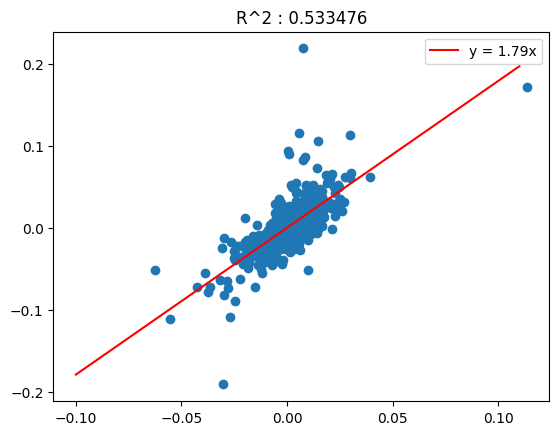

In [104]:
plt.scatter(x=df['NQ'], y=df['close'])

x_ = np.linspace(-0.1, 0.11, 12)
y_ = x_ * model.coef_
plt.plot(x_, y_, color = 'red', label = f'y = {model.coef_[0].round(2)}x')
plt.title(f"R^2 : {model.score(df['NQ'].values.reshape(-1,1), df['close']):2f}")
plt.legend()

In [327]:
def get_beta_hat(target_y : pd.DataFrame,
                 design_matrix : pd.DataFrame):
    """  
    beta_hat = (y - b xT)^T (y - b xT)

    differentiate wrt to beta gives
        beta_hat = (XT X)^-1 X^T y

    Matrix must be (500, 1) this is 2D not 1D
    """
    X        = design_matrix.values
    X        = X.reshape(-1, 1)
    y        = target_y.values
    y        = y.reshape(-1, 1)

    print('shape of', X.shape, y.shape)
    XtX      = X.T @ X
    Xty      = X.T @ y

    beta_hat = np.linalg.inv(XtX) @ Xty 
    return beta_hat, X,y

beta_hat, X,y = get_beta_hat(df['close'], df['NQ'])

shape of (500, 1) (500, 1)


In [328]:
def compute_resid(beta_hat, y, X):

    y_hat               = beta_hat * X 
    resids              = y - y_hat
    squared_error       = (y - y_hat) ** 2
    sum_squared_err     = sum(squared_error)

    mse                 = np.mean(squared_error)

    return y_hat, squared_error, sum_squared_err, mse, resids

def resid_analysis(y_hat, target_y, squared_error, mse):
    """
    Plot 1 : errors vs predicted values 
    """ 

    

In [329]:
y_hat, squared_error, sum_squared_err, mse, resids = compute_resid(beta_hat, y=y, X=X)
mse

np.float64(0.0004803733184960891)

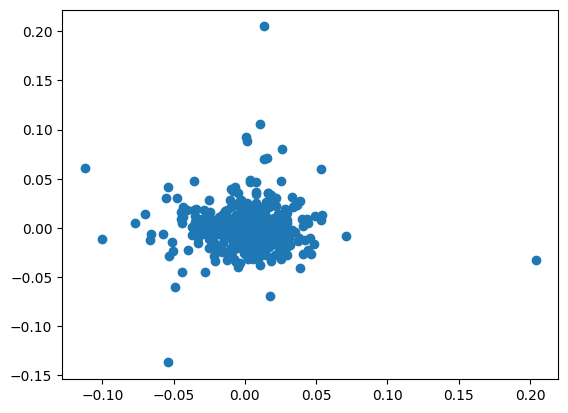

In [156]:
plt.scatter(y = resids, x = y_hat)

<Axes: ylabel='Count'>

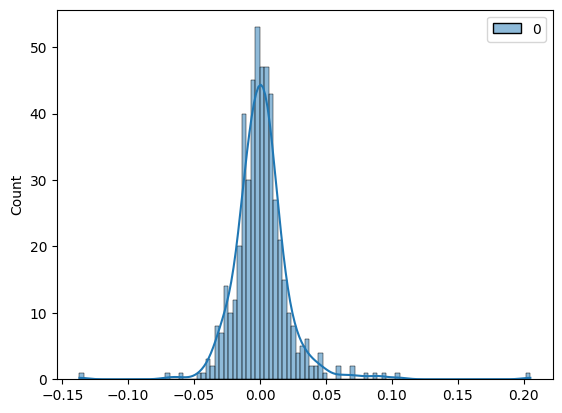

In [160]:
sns.histplot(resids, bins=100, kde=True)

In [180]:
import scipy.stats as stats
from fredapi import Fred
fred_api = Fred('e48d0413b1cd0a3b30b58d42225373de')

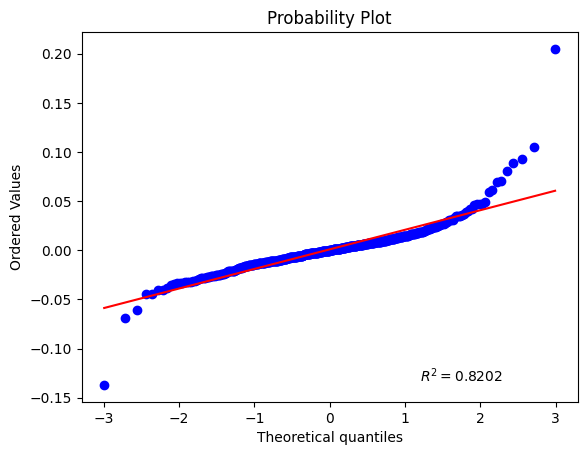

In [175]:
qq_plot = stats.probplot(x = resids.flatten(), dist = 'norm', plot = plt, rvalue=True)

In [255]:
VIX = fred_api.get_series('VIXCLS', observation_start='2023-09-25', observation_end='2025-09-25').to_frame('VIX')
VIX_3m = fred_api.get_series('VXVCLS', observation_start='2023-09-25', observation_end='2025-09-25').to_frame('VIX 3m')
VXN = fred_api.get_series('VXNCLS', observation_start='2023-09-25', observation_end='2025-09-25').to_frame('VXN')


In [258]:
VIXs = pd.merge(VIX, VIX_3m, left_index=True, right_index=True, how='outer')
VIXs = pd.merge(VXN, VIXs, left_index=True, right_index=True, how='outer')
VIXs_missing_mask = VIXs.index[VIXs['VIX'].isna() | VIXs['VIX 3m'].isna() | VIXs['VXN'].isna()]
display(VIXs.loc[VIXs_missing_mask])
VIXs.dropna(inplace=True)

,VXN,VIX,VIX 3m
2023-11-23,NaN,12.80,NaN
2023-12-25,NaN,NaN,NaN
2024-01-01,NaN,NaN,NaN
2024-01-15,NaN,13.25,NaN
2024-02-19,NaN,14.71,NaN
2024-03-29,NaN,NaN,NaN
2024-05-27,NaN,12.36,NaN
2024-06-19,NaN,12.48,NaN
2024-07-04,NaN,12.26,NaN
2024-09-02,NaN,15.55,NaN


In [259]:
VIXs.corr()

,VXN,VIX,VIX 3m
VXN,1.000000,0.960138,0.939470
VIX,0.960138,1.000000,0.974838
VIX 3m,0.939470,0.974838,1.000000


In [253]:
display(pd.DataFrame(np.cov(VIXs['VIX'], VIXs['VIX 3m']), index=['VIX', 'VIX 3m'], columns=['VIX', 'VIX 3m']))
corr_vix_vix3m = np.cov(VIXs['VIX'], VIXs['VIX 3m'])[0,1] / (VIXs['VIX'].std() * VIX_3m['VIX 3m'].std())
print('VIX-VIX3m corr', corr_vix_vix3m.round(2))

,VIX,VIX 3m
VIX,22.933207,16.995883
VIX 3m,16.995883,13.254336


VIX-VIX3m corr 0.97


In [269]:
from statsmodels.tsa.stattools import adfuller

print('p-value', adfuller(VIXs['VXN'])[1].round(4), '%')

p-value 0.0012 %


In [419]:
all_df = pd.merge(VIXs, df, how = 'inner', left_index=True, right_index=True)
with_rsi = all_df.dropna()

In [425]:
y = with_rsi['close'].values.reshape(-1, 1)
X = with_rsi[['rsi_14', 'NQ']]

XtX = X.T @ X 
Xty = X.T @ y
beta_hat = np.linalg.inv(XtX) @ Xty

y_fitted = X @ beta_hat.to_numpy()
resids = all_df['close'].to_frame('AVGO') - y_fitted.rename(columns={0:'AVGO'})
beta_hat

,0
0,0.000040
1,1.784544


In [ ]:
lst_squares_calc = np.linalg.lstsq(X, y, rcond=-1)
beta_hat_optimised  = lst_squares_calc[0]
residuals_optimised = lst_squares_calc[1]

y_fitted_optimised = X @ beta_hat_optimised
sum_squared_err_optimised = (y - y_fitted_optimised)**2
sum_squared_err_optimised.sum() / 499


In [407]:
import ta

In [471]:
# RSI
avgo_rsi = ta.momentum.RSIIndicator(close=df['close'], window=1).rsi()
df['rsi'] = avgo_rsi

df2 = df.copy()
df2['rsi'] = df2['rsi'].shift(-1)
df2.drop('rsi_14', inplace=True,axis=1)
df2.dropna(inplace=True)

In [4]:
from stock_data_functions import get_top_N_US_stocks, TickerData

In [5]:
# Get all stocks of top X market cap
top50_stocks = get_top_N_US_stocks(50)
top100_stocks = get_top_N_US_stocks(100)
top100_stocks.remove('BRK.B')



/Users/phillip/Desktop/Moon2/stock_data_functions.py:44: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(resp.text)
/Users/phillip/Desktop/Moon2/stock_data_functions.py:44: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(resp.text)


In [6]:
tickers = list(set(top100_stocks).difference(set(collected_tickers)))

In [7]:
tickers

['GOOG', 'COF', 'TSLA', 'LMT', 'XOM', 'GEV', 'PFE', 'NVDA', 'INTC']

In [ ]:
# Loop to get this data
failled = []

for tkr in ['NVDA', 'INTC', 'TSLA','XOM', 'COM', 'COF', 'GEV', 'LMT', 'PFE']:
    print(f"{tkr} — starting")
    try:
        x = TickerData(tkr, filing_date_gte="2023-09-26")

        try:
            stock_data_functions.fetch_in_six_month_chunks(x, tkr, months_per_chunk=2, cooldown_sec=60)
            print(f"{tkr} — success on first try")
        except:
            try:
                stock_data_functions.fetch_in_six_month_chunks(x, tkr, months_per_chunk=1, cooldown_sec=60)
                print(f"{tkr} — success on second try")
            except:
                try:
                    stock_data_functions.fetch_in_six_month_chunks(x, tkr, months_per_chunk=0.5, cooldown_sec=60)
                    print(f"{tkr} — success on third try")
                except:
                    failled.append(tkr)
                    print(f"{tkr} — all attempts failed")

    except Exception as e:
        failled.append(tkr)
        print(f"{tkr} — setup failed: {e}")

print("\nFailed tickers:", failled)



In [29]:
from glob import glob
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
import stock_data_functions
import numpy as np
import datetime as dt
from stock_data_functions import calc_log_rets, TickerData

In [ ]:
def get_all_returns_data():

    pattern             = os.path.join('Datasets', "*_5minute_2023-09_minute_level_data.csv")
    csv_files           = glob(pattern)
    collected_tickers   = [os.path.basename(f).split("_")[0] for f in csv_files]
    dfs                 = []
    try_again           = []

    # See what we have
    for i in collected_tickers:
        try:

            df              = stock_data_functions \
                            .get_minute_level_data(i, n =5, period='minute', start_date='2023-09-26')
            x               = df[['vwap']].rename(columns={'vwap':i})
            dfs.append(x)
        except Exception as e:
            print(e, i)
            try_again.append(i)
    
    return collected_tickers, try_again

In [30]:
df = pd.concat(dfs, axis=1)

t = df.index.time  # ndarray of datetime.time

df['session'] = np.select(
        [
            (t >= dt.time(4, 0))  & (t < dt.time(9, 30)),   # Pre-Market
            (t >= dt.time(9, 30)) & (t < dt.time(16, 0)),   # Regular
            (t >= dt.time(16, 0)) & (t < dt.time(20, 0)),   # Post-Market
        ],
        ['Pre-Market', 'Regular', 'Post-Market'],
        default='closed'
    )
regular_df = df[df['session'] == 'Regular']
regular_df = regular_df.iloc[:, :-1].apply(calc_log_rets)

In [50]:
sector_map = {
    'Biotech'             : ['GILD', 'ABBV', 'BSX', 'AMGN', 'ISRG', 'MDT', 'ABT', 'TMO', 'LLY', 'DHR', 'SYK',
                             'DHR'],
    'Consumer'            : ['HD', 'LOW', 'PG', 'PEP', 'AMZN', 'MRK', 'JNJ', 'DASH', 'KO', 'APP', 'PM', 'BKNG',
                             'TJX','COST', 'MCD'],
    'Healthcare'          : ['AMGN','MRK', 'UNH'],
    'Business Software'   : ['CSCO', 'NOW', 'ORCL', 'PANW', 'CRM', 'AMZN', 'CRWD', 'ADP', 'ADBE', 'IBM', 'MSFT'],
    'Telecoms'            : ['T', 'VZ', 'APH', 'TMUS', 'INTU'],
    'Mega-Cap Tech'       : ['AAPL', 'UBER', 'META', 'CSCO', 'ORCL', 'NFLX', 'AMZN', 'AVGO', 'PLTR', 'DASH','APP',
                             'GOOGL', 'IBM', 'MSFT', 'ANET'],
    'Financials'          : ['AXP', 'V', 'MA', 'BAC', 'SPGI', 'BLK', 'SCHW', 'BX', 'PGR', 'C', 'CB', 'MS', 'ACN'
                             ,'WFC', 'KKR', 'GS', 'JPM'] ,
    'Industrials'         : ['LIN', 'HON', 'PG', 'GE', 'BA', 'CAT', 'RTX'],
    'Semi'                : ['AMAT', 'TXN', 'QCOM', 'AMD', 'AVGO', 'MU', 'KLAC', 'ADI', 'ANET', 'LRCX'],
    'Power'               : ['ETN', 'HON', 'GE', 'NEE', 'DE'],
    'Oil & Gas'           : ['CVX', 'COP'],
    'Other'               : ['CMCSA', 'DIS', 'GE', 'BA', 'PGR', 'WMT', 'UNP','WELL', 'BKNG', 'RTX']
}

# Check if all the collected tickers are in the list
present         = set().union(*(set(v) for v in sector_map.values()))
missing         = set(collected_tickers).difference(present)
missing

# Map into df space
sector_dfs = {}
for i,v in sector_map.items():
    sector_dfs[i] = regular_df[v]


In [93]:
start_window = '2025-05-01'
end_window   = '2025-9-25'


def pca_analysis(tag : str, dfs, start_date=start_window, end_date = end_window):
    """
    Selects from the big dictionary of returns
    """
    if tag == False:
        df_i = dfs
    else:
        df_i              = dfs[tag] 
    
    df_i = df_i.loc[start_window : end_window].copy()

    print(df_i.index[0], df_i.index[-1])
    # Standardise
    standardised_rets = pd.DataFrame(StandardScaler().fit_transform(df_i),
                                     columns = df_i.columns,
                                     index   = df_i.index)
    pca      = PCA().fit(standardised_rets)
    
    loadings                = pd.DataFrame(pca.components_.T,
                                           index   = standardised_rets.columns,
                                           columns = [f'PC{i+1}' for i in range(len(standardised_rets.columns))])
    explained_var_by_PC     = pd.DataFrame(pca.explained_variance_ratio_,
                                           index = loadings.columns,
                                           columns = ['PC'])
    
    return loadings, explained_var_by_PC

In [176]:
def top_stocks_per_pc(loadings, n = 20, top=10):
    """  
    Given a dataframe of principle components and loadings
    """
    
    group       = {}
    for i in range(n):
        loadings_pc_i               = loadings.sort_values(by=f'PC{i+1}', ascending=False)
        group[f'PC{i+1}']           = loadings_pc_i.index[:top] 
        group[f'PC{i+1}']           = loadings_pc_i.iloc[:top, i]

    
    df = pd.concat(group, axis=0).to_frame('Value')
    df.reset_index(inplace=True)
    df.rename(columns={'level_0':'PC', 'level_1':'Ticker'}, inplace=True)
    df.set_index(['PC', 'Ticker'], inplace=True)
    
    return df    



In [196]:
stocks_per_pc = top_stocks_per_pc(loadings, n = 20, top=15)
#stocks_per_pc.groupby('PC')['Value'].agg(['mean', 'std', 'median']).sort_values(by='std', ascending=True)


In [237]:
def sector_centroids(loadings, sector_maps):
    rows = []
    for sector, names in sector_maps.items():
        names = [n for n in names if n in loadings.index]
        if not names: 
            continue
        rows.append(pd.DataFrame(loadings.loc[names].mean().rename(sector)))
    return pd.concat(rows, axis=1).T.sort_index()

sector_loads = sector_centroids(loadings, sector_map)
sector_by_pc = top_stocks_per_pc(sector_loads, top=15)
display(sector_by_pc.loc['PC7'])

,Value
Ticker,
Power,0.096406
Industrials,0.070644
Business Software,0.050418
Consumer,0.014263
Other,0.011322
Biotech,0.008378
Mega-Cap Tech,-0.005306
Oil & Gas,-0.014264
Semi,-0.026417


In [224]:
def top_abs_per_pc(loadings, n=10):
    out = []
    for pc in loadings.columns:
        s = loadings[pc].sort_values(key=lambda x: x.abs(), ascending=False).head(n)
        out.append(pd.DataFrame({"pc": pc, "ticker": s.index, "loading": s.values}))
    return pd.concat(out, ignore_index=True)

tops = top_abs_per_pc(loadings, n=15)

In [225]:
tops

,pc,ticker,loading
0,PC1,GS,0.185300
1,PC1,MS,0.184002
2,PC1,AXP,0.182783
3,PC1,BX,0.181289
4,PC1,KKR,0.179093
...,...,...,...
1360,PC91,QCOM,0.099865
1361,PC91,JPM,0.099219
1362,PC91,BX,0.097259
1363,PC91,MA,0.095792


In [ ]:
sector_cross_section = sector_by_pc.xs('PC1')
loading_pc_i         = sector_cross_section.iloc[0]
sector_i             = sector_cross_section.index[0:3]
sector_i



Index(['Financials', 'Semi', 'Business Software'], dtype='object', name='Ticker')

In [201]:
loadings, explained_var_by_PC = pca_analysis(tag = False, dfs =regular_df)

2025-05-01 09:30:00-04:00 2025-09-25 15:55:00-04:00


In [202]:
loadings_N          = loadings.iloc[:, :5].copy()
loadings_N['Total'] = loadings_N.sum(axis=1)
loadings_N.sort_values(by='PC2', ascending=False).head(60)

,PC1,PC2,PC3,PC4,PC5,Total
KO,-0.008390,0.238502,0.095979,-0.022183,0.102149,0.406058
PG,0.017173,0.235783,-0.004774,0.035199,0.037239,0.320621
JNJ,-0.006388,0.224924,-0.019985,0.072221,-0.074349,0.196423
VZ,-0.011950,0.222769,0.097321,-0.054000,0.101751,0.355891
MCD,0.005015,0.204226,0.084745,-0.008347,0.067444,0.353082
CB,0.032550,0.189548,0.148258,-0.135604,0.099073,0.333824
PEP,0.006272,0.187884,-0.063065,-0.021884,0.006326,0.115533
AMGN,0.042407,0.187218,-0.122394,0.135545,-0.052124,0.190653
LIN,0.088936,0.181760,-0.035487,-0.064803,0.056456,0.226862
ABT,0.020335,0.180427,0.029865,0.130762,-0.036247,0.325142


,PC,cumsum
PC1,0.219944,0.219944
PC2,0.092807,0.312750
PC3,0.045853,0.358603
PC4,0.028990,0.387593
PC5,0.027058,0.414650
PC6,0.025496,0.440146
PC7,0.022125,0.462271
PC8,0.019616,0.481887
PC9,0.018605,0.500492
PC10,0.017950,0.518442


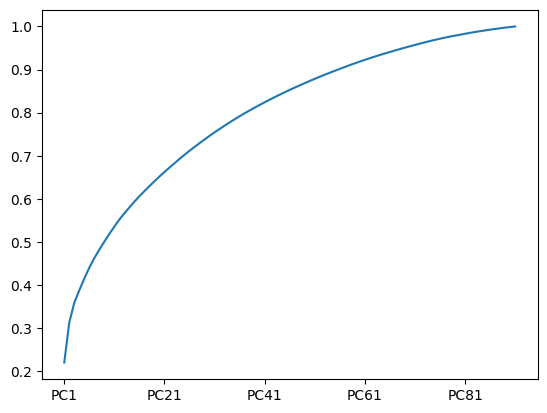

In [203]:
explained_var_by_PC['cumsum'] = explained_var_by_PC['PC'].cumsum()
explained_var_by_PC['cumsum'].plot()
display(explained_var_by_PC.head(10))

In [76]:
corr = sector_dfs['Mega-Cap Tech'].corr()
corr = corr.stack().to_frame('Corr').reset_index()
corr = corr[corr['level_0'] != corr['level_1']].copy()
corr = corr.drop_duplicates(subset=['Corr'])
corr.sort_values(by='Corr', ascending=False).head(60)

,level_0,level_1,Corr
36,META,AMZN,0.634795
119,AVGO,ANET,0.580400
43,META,MSFT,0.578626
103,AMZN,MSFT,0.564318
101,AMZN,GOOGL,0.517246
104,AMZN,ANET,0.506671
41,META,GOOGL,0.477966
44,META,ANET,0.466980
209,MSFT,ANET,0.462961
21,UBER,AMZN,0.442633


ANET

In [234]:
start_window = '2025-5-01'
end_window   = '2025-9-25'
df = regular_df.loc[start_window : end_window]

### Correlation 
tech_df       = pd.DataFrame(StandardScaler().fit_transform(tech_df),
                        index=tech_df.index,
                        columns=tech_df.columns)

pca_model = PCA()
pca_model.fit(tech_df)

loadings = pd.DataFrame(pca_model.components_.T,
                        index= tech_df.columns,
                        columns= [f'PC{i+1}' for i in range(len(tech_df.columns))])

explained_var = pd.DataFrame(pca_model.explained_variance_ratio_,
                             index = loadings.columns,
                             columns = ['Variance Ratio']
                             ).round(2) * 100


display(explained_var.sort_values(by = 'Variance Ratio', ascending=False).head(5))
display(loadings)



,Variance Ratio
PC1,36.0
PC2,9.0
PC3,7.0
PC4,7.0
PC5,6.0


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13
AAPL,0.280035,0.070174,-0.064232,0.016781,0.515471,0.498031,-0.229097,-0.240805,0.358178,0.340608,0.182003,0.030144,-0.098451
CSCO,0.222135,0.430048,-0.178766,0.356792,0.361281,-0.094330,0.613750,0.148282,-0.250244,0.042613,0.014994,-0.059148,-0.014044
CRM,0.273159,0.031052,0.568390,-0.030957,-0.052868,-0.168679,-0.144770,-0.011836,-0.447093,0.585368,-0.020469,0.060336,0.037961
AMD,0.321115,-0.152587,-0.280035,-0.108760,0.103703,-0.139908,-0.154104,0.131223,0.060292,0.123911,-0.666182,-0.487237,0.108949
TMUS,0.032940,0.727866,-0.163337,-0.626583,-0.167221,-0.010074,-0.092701,-0.091304,-0.022278,0.005785,-0.002797,0.016295,0.063590
AVGO,0.308670,-0.190979,-0.260569,-0.100668,0.034576,-0.368650,-0.149000,-0.094304,-0.140081,-0.082701,0.671846,-0.358662,0.124698
MU,0.320645,-0.190661,-0.314132,-0.159345,0.092661,-0.342427,-0.038858,0.107889,0.026605,0.018409,-0.092062,0.723405,-0.254827
IBM,0.208308,0.344480,-0.176199,0.639045,-0.409372,-0.029553,-0.463114,-0.063987,0.038831,-0.046253,-0.031383,0.062405,-0.054433
MSFT,0.325822,-0.035177,0.197510,-0.105631,0.034405,0.259024,-0.046249,-0.184860,-0.366819,-0.519479,-0.101362,-0.129107,-0.553614
INTU,0.262092,0.172430,0.535964,0.013718,0.103693,-0.397388,0.059186,0.043138,0.600102,-0.277805,-0.004171,-0.051971,0.008994


In [242]:
loadings_top3 = loadings.iloc[:, 0:5].copy()
loadings_top3['Total'] = loadings_top3.sum(axis=1)
loadings_top3.sort_values(ascending=False, by='PC1')

,PC1,PC2,PC3,PC4,PC5,Total
AMZN,0.348484,-0.079086,0.073498,-0.006766,0.007833,0.343964
MSFT,0.325822,-0.035177,0.197510,-0.105631,0.034405,0.416928
AMD,0.321115,-0.152587,-0.280035,-0.108760,0.103703,-0.116565
MU,0.320645,-0.190661,-0.314132,-0.159345,0.092661,-0.250831
AVGO,0.308670,-0.190979,-0.260569,-0.100668,0.034576,-0.208970
UBER,0.285010,-0.046066,0.021946,-0.104272,-0.329685,-0.173067
AAPL,0.280035,0.070174,-0.064232,0.016781,0.515471,0.818228
CRM,0.273159,0.031052,0.568390,-0.030957,-0.052868,0.788776
APP,0.272790,-0.158935,-0.077327,-0.029285,-0.514001,-0.506758
INTU,0.262092,0.172430,0.535964,0.013718,0.103693,1.087896


In [143]:
regular_df.columns

Index(['T', 'AAPL', 'AXP', 'META', 'UBER', 'LIN', 'CSCO', 'DIS', 'GE', 'CRM',
       'AMD', 'AMZN', 'TMUS', 'AVGO', 'MRK', 'MU', 'ABT', 'MS', 'KO', 'WFC',
       'UNH', 'APP', 'CAT', 'GS', 'GOOGL', 'IBM', 'MSFT', 'PM', 'MCD', 'RTX',
       'INTU'],
      dtype='object')

In [132]:
loadings.sort_values(by='PC1', ascending=False)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31
AMZN,0.278375,-0.064727,-0.105566,0.036827,-0.041837,-0.232824,-0.164862,-0.012929,0.008095,-0.010899,...,0.013420,0.058724,-0.015024,-0.010992,-0.537961,0.259780,0.037142,0.632312,0.022030,-0.017552
META,0.260400,-0.125324,-0.150269,-0.043131,-0.106147,-0.247844,-0.229359,0.089304,0.068645,0.086648,...,-0.052837,-0.070829,-0.023674,-0.122386,-0.360977,-0.227835,-0.003438,-0.612738,0.018450,0.129049
MU,0.254118,-0.073476,0.067634,-0.040956,0.159015,0.405929,0.016312,-0.053459,-0.008092,-0.078966,...,0.095694,0.073738,-0.081028,0.736418,-0.151473,-0.055848,-0.011687,-0.073433,0.042811,0.170448
AMD,0.243745,-0.120991,0.001871,-0.014816,0.119983,0.278161,-0.107854,0.087625,-0.064236,-0.069591,...,0.188912,0.112939,-0.413528,-0.466970,0.095605,0.011874,0.025972,0.096863,-0.009239,0.101172
AVGO,0.241129,-0.109467,-0.000848,-0.076147,0.034445,0.424182,0.073093,0.022408,0.011438,-0.100246,...,-0.059702,0.000759,0.296638,-0.357954,0.095854,0.167435,0.042590,-0.047444,0.005872,0.237672
MSFT,0.230958,-0.136820,-0.175163,0.064755,-0.048684,-0.233539,-0.086971,-0.049539,0.048625,-0.092516,...,-0.241286,0.073327,-0.280515,0.197661,0.621252,-0.013438,-0.024116,0.139112,-0.014948,-0.018236
APP,0.217217,-0.080745,-0.002484,-0.229651,-0.088779,0.082077,0.037269,-0.076726,0.144427,0.328091,...,-0.032901,0.158432,0.043504,0.017867,0.080975,0.064358,-0.032359,0.070896,0.035753,0.290278
GOOGL,0.212280,-0.153324,-0.091140,0.052011,-0.003757,-0.280621,-0.243120,-0.044048,-0.083765,-0.175299,...,0.452605,-0.174668,0.189131,0.021287,0.275520,0.049410,-0.034889,-0.021920,-0.003057,0.165128
GS,0.207909,0.343022,0.119001,-0.038765,0.050153,-0.037216,0.016700,-0.131632,-0.121348,-0.020270,...,0.020481,0.033375,-0.059808,-0.077582,0.020032,-0.018167,-0.447540,-0.034071,0.706605,-0.208399
MS,0.197911,0.367206,0.140513,-0.035547,0.019133,-0.017514,0.035885,-0.132744,-0.115925,-0.009277,...,0.013822,0.056324,-0.047379,-0.052877,-0.032655,-0.160055,-0.491832,0.038043,-0.679750,-0.019638


In [ ]:

pca = PCA(n_components=None)   
pca.fit(rets)

# Components (eigenvectors, loadings)
loadings = pd.DataFrame(
    pca.components_.T,
    index=rets.columns,
    columns=[f"PC{i+1}" for i in range(len(rets.columns))]
)

# Explained variance ratio
explained_var = pd.Series(pca.explained_variance_ratio_,
                          index=loadings.columns)

print("Explained variance ratio:")
print(explained_var)

print("\nLoadings (feature weights per PC):")
print(loadings)

# Transform data into PC scores
scores = pd.DataFrame(
    pca.transform(rets),
    index=rets.index,
    columns=loadings.columns
)


In [99]:
regular_df.corr()

,T,AAPL,AXP,META,UBER,LIN,CSCO,DIS,GE,CRM,...,APP,CAT,GS,GOOGL,IBM,MSFT,PM,MCD,RTX,INTU
T,1.000000,0.078373,0.099638,-0.013916,0.042197,0.143567,0.109648,0.138755,0.096943,0.022973,...,-0.024117,0.084394,0.141460,-0.032443,0.135039,-0.000583,0.217297,0.221176,0.197026,0.028085
AAPL,0.078373,1.000000,0.372664,0.352374,0.307554,0.189624,0.285194,0.289421,0.324581,0.294443,...,0.271034,0.347624,0.401389,0.403516,0.237367,0.390360,0.018968,0.147872,0.159825,0.282322
AXP,0.099638,0.372664,1.000000,0.394363,0.370532,0.301838,0.380554,0.419138,0.493767,0.347123,...,0.361935,0.553458,0.672235,0.342702,0.373399,0.386137,0.114903,0.200021,0.313614,0.344562
META,-0.013916,0.352374,0.394363,1.000000,0.387311,0.133554,0.237551,0.303561,0.383025,0.344497,...,0.419095,0.414695,0.392994,0.477966,0.312323,0.578626,-0.012074,0.067352,0.147841,0.312560
UBER,0.042197,0.307554,0.370532,0.387311,1.000000,0.185240,0.230131,0.264149,0.371172,0.320418,...,0.335521,0.364357,0.371651,0.359109,0.230856,0.381433,0.047722,0.110349,0.159260,0.287043
LIN,0.143567,0.189624,0.301838,0.133554,0.185240,1.000000,0.273443,0.216977,0.254144,0.152982,...,0.096723,0.305300,0.278086,0.141243,0.264700,0.170259,0.150993,0.281137,0.207275,0.210446
CSCO,0.109648,0.285194,0.380554,0.237551,0.230131,0.273443,1.000000,0.273030,0.284688,0.216947,...,0.211900,0.341890,0.382317,0.209012,0.290392,0.263624,0.112344,0.199451,0.204232,0.269185
DIS,0.138755,0.289421,0.419138,0.303561,0.264149,0.216977,0.273030,1.000000,0.300239,0.251107,...,0.266228,0.371030,0.410905,0.253149,0.258284,0.272917,0.059636,0.154509,0.204651,0.223733
GE,0.096943,0.324581,0.493767,0.383025,0.371172,0.254144,0.284688,0.300239,1.000000,0.303697,...,0.335304,0.441871,0.491335,0.307432,0.308000,0.364570,0.084170,0.139340,0.323422,0.297804
CRM,0.022973,0.294443,0.347123,0.344497,0.320418,0.152982,0.216947,0.251107,0.303697,1.000000,...,0.288768,0.323019,0.334812,0.312456,0.217967,0.404552,0.010292,0.111270,0.145724,0.397703
